# Length scale bounds

Sigurd Carlen, September 2019.

To use different length scale bounds we need to pass the optional paramter acq_optimizer_kwargs =  to the optimize.

This parameter is a dict containing optional parameters for the optimizer. An example:
`acq_optimizer_kwargs = {
"length_scale_bounds":[(0.1,1),(0.5,1.5)],
"length_scale":[1.0,3.0]
}`

For a 2-dimensional problem the length_scale_bounds must be a list of length 2 containing lower and upper bounds as tuples.
length_scale is a list of numbers defining the length scale for each dimension.

In [47]:
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")
from ProcessOptimizer.learning import ExtraTreesRegressor
from ProcessOptimizer import Optimizer

<Figure size 432x288 with 0 Axes>

In [48]:
acq_optimizer_kwargs = {"length_scale_bounds" :[(0.01,0.02)]}

In [49]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 5, acq_optimizer="sampling",acq_optimizer_kwargs=acq_optimizer_kwargs)

In [50]:

noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize
def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

In [51]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level=0.0) for x_i in x])

In [52]:
from ProcessOptimizer.acquisition import gaussian_ei

def plot_optimizer(opt, x, fx):
    model = opt.models[-1]
    x_model = opt.space.transform(x.tolist())

    # Plot true function.
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot Model(x) + contours
    y_pred, sigma = model.predict(x_model, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(opt.Xi, opt.yi,
             "r.", markersize=8, label="Observations")

    acq = gaussian_ei(x_model, model, y_opt=np.min(opt.yi))
    # shift down to make a better plot
    acq = 4*acq - 2
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')
    
    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')


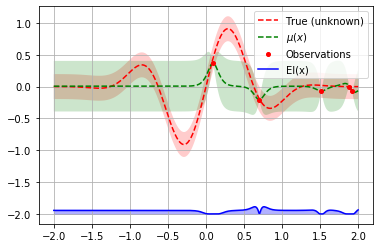

In [53]:
for i in range(5):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)
plot_optimizer(opt, x, fx)

We see that some minima is found and "exploited"

Now lets try to set kappa and xi using'to other values and pass it to the optimizer:

In [54]:
acq_optimizer_kwargs = {"length_scale_bounds" :[(0.01,0.02)]}

In [55]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 5, acq_optimizer="sampling",acq_optimizer_kwargs=acq_optimizer_kwargs)

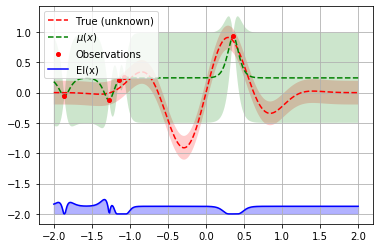

In [56]:
for i in range(5):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)